# Background: 
* We sent emails to DL student with project completion status >= 3 for an auto-admissions in AI/SDC/Robo on 6/5, 9/25 and 10/13.
* There're 5 projects in DL.

# 2 Questions to answer in this analysis:
* Are the conversion rates of email groups different between Grad.(project = 5) and not-yet-grad (project = 3/4) groups? - 6/5 data
* Is sending emails improving conversion rate? (overall, active, graduated) - 9/25 data

In [145]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
from scipy import stats
import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegression
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# import 6/5 and 9/25 data
df_0605_raw = pd.read_csv('DLND-06-05.csv')
df_0925_raw = pd.read_csv('DLND-09-25.csv')

## Question1. Are the conversion rates of email groups different between Grad. (project = 5) and not-yet-grad (project = 3/4) groups? - 6/5 data

In [3]:
df_0605_raw.head()

,Projects Passed,Status,User,First Name,Last Name,Email,ip_country_code,Mentor,Profile
0,3,Active,10089403351,é‘«,é‡‘,2120100202@email.szu.edu.cn,NaN,NaN,https://profiles.udacity.com/u/2267
1,3,Active,10157053022,Lijun,WANG,wljjlu@163.com,NaN,NaN,https://profiles.udacity.com/u/lijunwang
2,3,Active,10369378814,Deborah,Mesquita,mesquita.deh@gmail.com,NaN,NaN,NaN
3,3,Active,10183345181,meiyan,lin,1017806276@qq.com,NaN,NaN,NaN
4,3,Active,204065671,Daniel,Dubats,ddd5ye@virginia.edu,US,NaN,NaN


In [5]:
df_0605_raw.groupby(['Projects Passed','Status'])['User'].count()

Projects Passed  Status   
3                Active        295
4                Active        480
5                Completed    1263
Name: User, dtype: int64

In [162]:
user_list = []
for u in df_0605_raw['User']:
    user_list.append(u)
user_list = ','.join("'"+str(e)+"'" for e in user_list)

In [36]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql = "select distinct user_id,nd_key\
       from nd_enrolls a\
       where has_payment and nd_key in ('nd889','nd013','nd209')\
         and user_id in ({0})".format(user_list)
df_0605_convert = pd.read_sql(sql,conn_laurel)

In [37]:
df_0605_convert.columns = ['User','nd_key']
df_0605_convert.head()

,User,nd_key
0,u5232340,nd013
1,u2011049,nd209
2,u6724,nd013
3,8489035320,nd889
4,6791689572,nd013


In [38]:
df_0605 = pd.merge(df_0605_raw,df_0605_convert,on='User',how='left')
df_0605.head()

,Projects Passed,Status,User,First Name,Last Name,Email,ip_country_code,Mentor,Profile,nd_key
0,3,Active,10089403351,é‘«,é‡‘,2120100202@email.szu.edu.cn,NaN,NaN,https://profiles.udacity.com/u/2267,NaN
1,3,Active,10157053022,Lijun,WANG,wljjlu@163.com,NaN,NaN,https://profiles.udacity.com/u/lijunwang,nd013
2,3,Active,10369378814,Deborah,Mesquita,mesquita.deh@gmail.com,NaN,NaN,NaN,NaN
3,3,Active,10183345181,meiyan,lin,1017806276@qq.com,NaN,NaN,NaN,NaN
4,3,Active,204065671,Daniel,Dubats,ddd5ye@virginia.edu,US,NaN,NaN,NaN


In [40]:
df_0605 = df_0605.assign(convert = df_0605['nd_key'].apply(lambda x: 1 if x == 'nd013' or x == 'nd209' or x == 'nd889' else 0))
df_0605.head()

,Projects Passed,Status,User,First Name,Last Name,Email,ip_country_code,Mentor,Profile,nd_key,convert
0,3,Active,10089403351,é‘«,é‡‘,2120100202@email.szu.edu.cn,NaN,NaN,https://profiles.udacity.com/u/2267,NaN,0
1,3,Active,10157053022,Lijun,WANG,wljjlu@163.com,NaN,NaN,https://profiles.udacity.com/u/lijunwang,nd013,1
2,3,Active,10369378814,Deborah,Mesquita,mesquita.deh@gmail.com,NaN,NaN,NaN,NaN,0
3,3,Active,10183345181,meiyan,lin,1017806276@qq.com,NaN,NaN,NaN,NaN,0
4,3,Active,204065671,Daniel,Dubats,ddd5ye@virginia.edu,US,NaN,NaN,NaN,0


In [47]:
df_0605_active = df_0605.query("Status == 'Active'")
df_0605_active_c = df_0605_active.query('convert == 1')
n1 = df_0605_active.shape[0]
obs_v1 = df_0605_active_c.shape[0]

df_0605_complete = df_0605.query("Status == 'Completed'")
df_0605_complete_c = df_0605_complete.query('convert == 1')
n2 = df_0605_complete.shape[0]
obs_v2 = df_0605_complete_c.shape[0]

print("{0} students received emails when active, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students received emails when completed, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

807 students received emails when active, 325 of them enrolled in AI/SDC/Robo. (0.40272614622057)
1386 students received emails when completed, 827 of them enrolled in AI/SDC/Robo. (0.5966810966810967)


In [48]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.5253077975376197; Pool variance: 0.00011370702935877558


In [49]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails when active: mean is {0} and variance is {1}".format(m2,sd2))
print("Students received emails when completed: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails when active: mean is 0.5966810966810967 and variance is 0.0001736311439715299
Students received emails when completed: mean is 0.40272614622057 and variance is 0.0002980641850940497


In [50]:
# 95% CI:
g1_lower = m1-1.96*np.sqrt(sd1/n1)
g1_upper = m1+1.96*np.sqrt(sd1/n1)
g2_lower = m2-1.96*np.sqrt(sd2/n2)
g2_upper = m2+1.96*np.sqrt(sd2/n2)
print("for student received emails when active, 95% of CI conversion rate: [{0},{1}]".format(g2_lower,g2_upper))
print("for student received emails when complete, 95% of CI conversion rate: [{0},{1}]".format(g1_lower,g1_upper))

for student received emails when active, 95% of CI conversion rate: [0.5959873702052499,0.5973748231569435]
for student received emails when complete, 95% of CI conversion rate: [0.40153497497401947,0.40391731746712056]


In [53]:
# z test
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is 8.771764490067964; 90% z score is 1.6448536269514722


In [55]:
# bayesian ab testing
with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=2, beta=2)
    prior_v2 = pm.Beta('prior_v2', alpha=2, beta=2)
    #prior_v1 = pm.Normal('prior_v1', mu=m1, sd=sd1)
    #prior_v2 = pm.Normal('prior_v2', mu=m2, sd=sd2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n1, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n2, p=prior_v2, observed=obs_v2)
    
    ## define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)
    
    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -48.011, ||grad|| = 155.3: 100%|██████████| 8/8 [00:00<00:00, 73.84it/s]   
100%|██████████| 50500/50500 [00:10<00:00, 4599.41it/s]


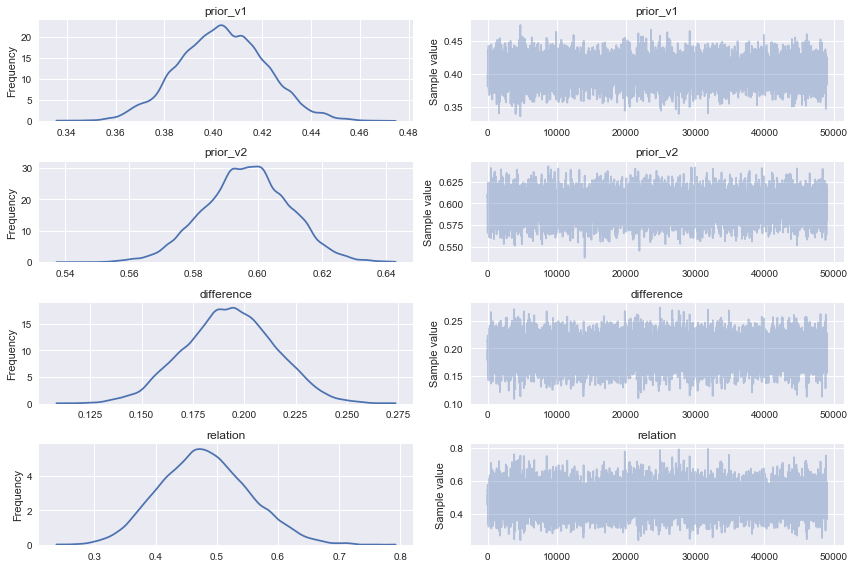

In [56]:
_ = pm.traceplot(trace[1000:], grid=True)

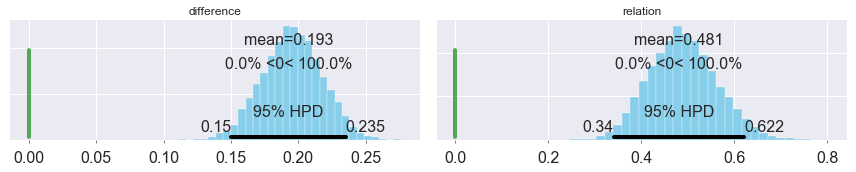

In [57]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

### Result: Conversion Rate in DL Graduate Students are higher than DL Active Students.

### to be fair with 09/25 data, we pick the time 09/25 as stop time for 6/5 campaign

In [163]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql = "select distinct user_id,nd_key\
       from nd_enrolls a\
       where has_payment and nd_key in ('nd889','nd013','nd209')\
         and access_started_at < '2017-09-25'\
         and user_id in ({0})".format(user_list)
df_0605_convert_time = pd.read_sql(sql,conn_laurel)

In [165]:
df_0605_convert_time.columns = ['User','nd_key']
df_0605_convert_time.head()

,User,nd_key
0,u5232340,nd013
1,u2011049,nd209
2,u6724,nd013
3,6791689572,nd013
4,7662419265,nd889


In [166]:
df_0605_t = pd.merge(df_0605_raw,df_0605_convert_time,on='User',how='left')
df_0605_t.head()

,Projects Passed,Status,User,First Name,Last Name,Email,ip_country_code,Mentor,Profile,nd_key
0,3,Active,10089403351,é‘«,é‡‘,2120100202@email.szu.edu.cn,NaN,NaN,https://profiles.udacity.com/u/2267,NaN
1,3,Active,10157053022,Lijun,WANG,wljjlu@163.com,NaN,NaN,https://profiles.udacity.com/u/lijunwang,nd013
2,3,Active,10369378814,Deborah,Mesquita,mesquita.deh@gmail.com,NaN,NaN,NaN,NaN
3,3,Active,10183345181,meiyan,lin,1017806276@qq.com,NaN,NaN,NaN,NaN
4,3,Active,204065671,Daniel,Dubats,ddd5ye@virginia.edu,US,NaN,NaN,NaN


In [167]:
df_0605_t = df_0605_t.assign(convert = df_0605_t['nd_key'].apply(lambda x: 1 if x == 'nd013' or x == 'nd209' or x == 'nd889' else 0))
df_0605_t.head()

,Projects Passed,Status,User,First Name,Last Name,Email,ip_country_code,Mentor,Profile,nd_key,convert
0,3,Active,10089403351,é‘«,é‡‘,2120100202@email.szu.edu.cn,NaN,NaN,https://profiles.udacity.com/u/2267,NaN,0
1,3,Active,10157053022,Lijun,WANG,wljjlu@163.com,NaN,NaN,https://profiles.udacity.com/u/lijunwang,nd013,1
2,3,Active,10369378814,Deborah,Mesquita,mesquita.deh@gmail.com,NaN,NaN,NaN,NaN,0
3,3,Active,10183345181,meiyan,lin,1017806276@qq.com,NaN,NaN,NaN,NaN,0
4,3,Active,204065671,Daniel,Dubats,ddd5ye@virginia.edu,US,NaN,NaN,NaN,0


In [168]:
df_0605_active = df_0605_t.query("Status == 'Active'")
df_0605_active_c = df_0605_active.query('convert == 1')
n1 = df_0605_active.shape[0]
obs_v1 = df_0605_active_c.shape[0]

df_0605_complete = df_0605_t.query("Status == 'Completed'")
df_0605_complete_c = df_0605_complete.query('convert == 1')
n2 = df_0605_complete.shape[0]
obs_v2 = df_0605_complete_c.shape[0]

print("{0} students received emails when active, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students received emails when completed, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

802 students received emails when active, 294 of them enrolled in AI/SDC/Robo. (0.36658354114713215)
1372 students received emails when completed, 781 of them enrolled in AI/SDC/Robo. (0.5692419825072886)


In [169]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.4944802207911684; Pool variance: 0.00011498138548182417


In [170]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails when active: mean is {0} and variance is {1}".format(m2,sd2))
print("Students received emails when completed: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails when active: mean is 0.5692419825072886 and variance is 0.00017872124479479615
Students received emails when completed: mean is 0.36658354114713215 and variance is 0.0002895262450213978


In [171]:
# z test
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is 9.119176669395355; 90% z score is 1.6448536269514722


## Question2. Is sending emails improving conversion rate? (overall, active, graduated) - 9/25 data

In [78]:
df_0925_raw = df_0925_raw[:4185]
df_0925_raw.head()

,user_id,email,version,locale,term_id,access_started_at,count_projects_completed,project_completed,cohort_id,nd013_purchase_date,nd013_after_nd101_started,nd889_purchase_date,nd889_after_nd101_started,nd209_purchase_date,nd209_after_nd101_started,emailed
0,u95848,jrenzhile@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Translation Project, Generate TV Scripts, Gene...",17.0,2017-06-05,TRUE,NaN,FALSE,NaN,FALSE,Yes
1,8244503642,wyllmein2000@21cn.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate Faces, Image Classification, Your fir...",17.0,2017-07-03,TRUE,NaN,FALSE,2017-05-10,TRUE,No
2,380288663,xia.fei09@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Image Classification, Tra...",17.0,2017-01-06,FALSE,2016-12-02,FALSE,NaN,FALSE,No
3,10161001520,alexpanasucla@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Translation Project, Imag...",17.0,2017-06-09,TRUE,NaN,FALSE,NaN,FALSE,Yes
4,304937546,gaston.farina@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Translation Project, Your...",17.0,2017-02-06,TRUE,2017-06-05,TRUE,NaN,FALSE,Yes


In [80]:
# exclude those already purchased
df_0925_raw = df_0925_raw.assign(purchased = 0)
df_0925_raw['purchased'] = np.where((df_0925_raw['nd013_after_nd101_started']=="TRUE")
                                   |(df_0925_raw['nd889_after_nd101_started']=="TRUE")
                                   |(df_0925_raw['nd209_after_nd101_started']=="TRUE"),1,0)

In [86]:
df_0925_raw.groupby(['purchased','emailed','count_projects_completed'])['user_id'].count()

purchased  emailed  count_projects_completed
0          No       3.0                          166
                    4.0                          162
                    5.0                         1012
           Yes      3.0                          128
                    4.0                           72
                    5.0                         1293
1          No       3.0                           13
                    4.0                           18
                    5.0                          546
           Yes      3.0                           16
                    4.0                           17
                    5.0                          742
Name: user_id, dtype: int64

In [87]:
user_list = []
for u in df_0925_raw['user_id']:
    user_list.append(u)
user_list = ','.join("'"+str(e)+"'" for e in user_list)

In [88]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql = "select distinct user_id,nd_key\
       from nd_enrolls a\
       where has_payment and nd_key in ('nd889','nd013','nd209')\
         and user_id in ({0})".format(user_list)
df_0925_convert = pd.read_sql(sql,conn_laurel)

In [131]:
df_0925 = pd.merge(df_0925_raw,df_0925_convert,on='user_id',how='left')
df_0925.head()

,user_id,email,version,locale,term_id,access_started_at,count_projects_completed,project_completed,cohort_id,nd013_purchase_date,nd013_after_nd101_started,nd889_purchase_date,nd889_after_nd101_started,nd209_purchase_date,nd209_after_nd101_started,emailed,purchased,nd_key
0,u95848,jrenzhile@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Translation Project, Generate TV Scripts, Gene...",17.0,2017-06-05,TRUE,NaN,FALSE,NaN,FALSE,Yes,1,nd013
1,8244503642,wyllmein2000@21cn.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate Faces, Image Classification, Your fir...",17.0,2017-07-03,TRUE,NaN,FALSE,2017-05-10,TRUE,No,1,nd013
2,8244503642,wyllmein2000@21cn.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate Faces, Image Classification, Your fir...",17.0,2017-07-03,TRUE,NaN,FALSE,2017-05-10,TRUE,No,1,nd209
3,380288663,xia.fei09@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Image Classification, Tra...",17.0,2017-01-06,FALSE,2016-12-02,FALSE,NaN,FALSE,No,0,nd013
4,380288663,xia.fei09@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Image Classification, Tra...",17.0,2017-01-06,FALSE,2016-12-02,FALSE,NaN,FALSE,No,0,nd889


In [132]:
df_0925 = df_0925.assign(convert = df_0925['nd_key'].apply(lambda x: 1 if x == 'nd013' or x == 'nd209' or x == 'nd889' else 0))
df_0925.head()

,user_id,email,version,locale,term_id,access_started_at,count_projects_completed,project_completed,cohort_id,nd013_purchase_date,nd013_after_nd101_started,nd889_purchase_date,nd889_after_nd101_started,nd209_purchase_date,nd209_after_nd101_started,emailed,purchased,nd_key,convert
0,u95848,jrenzhile@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Translation Project, Generate TV Scripts, Gene...",17.0,2017-06-05,TRUE,NaN,FALSE,NaN,FALSE,Yes,1,nd013,1
1,8244503642,wyllmein2000@21cn.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate Faces, Image Classification, Your fir...",17.0,2017-07-03,TRUE,NaN,FALSE,2017-05-10,TRUE,No,1,nd013,1
2,8244503642,wyllmein2000@21cn.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate Faces, Image Classification, Your fir...",17.0,2017-07-03,TRUE,NaN,FALSE,2017-05-10,TRUE,No,1,nd209,1
3,380288663,xia.fei09@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Image Classification, Tra...",17.0,2017-01-06,FALSE,2016-12-02,FALSE,NaN,FALSE,No,0,nd013,1
4,380288663,xia.fei09@gmail.com,1.0.0,en-us,5.0,2017-01-27 22:00:00,5.0,"Generate TV Scripts, Image Classification, Tra...",17.0,2017-01-06,FALSE,2016-12-02,FALSE,NaN,FALSE,No,0,nd889,1


In [133]:
df_0925.groupby(['cohort_id'])['user_id'].count()

cohort_id
17.0     2760
19.0      174
40.0      844
70.0       56
81.0       42
108.0      49
109.0     358
146.0       3
150.0       5
161.0     139
176.0       2
194.0       7
214.0       5
250.0       2
Name: user_id, dtype: int64

In [107]:
# exclude previous cohorts since we ran one campaign on 6/5 which is impacting cohort 17
# only look at cohort 109, 161 and 214
df_0925 = df_0925.loc[(df_0925['cohort_id']==109)|(df_0925['cohort_id']==161)|(df_0925['cohort_id']==214)]

In [108]:
df_0925.groupby(['cohort_id'])['user_id'].count()

cohort_id
109.0    358
161.0    139
214.0      5
Name: user_id, dtype: int64

In [109]:
df_0925.groupby(['purchased','convert'])['user_id'].count()

purchased  convert
0          0          304
           1           86
1          1          112
Name: user_id, dtype: int64

In [110]:
# only look at not-yet-converted students
df_0925_p = df_0925.query('purchased==0')

### overall : does sending emails improve conversion rate?

In [111]:
df_0925_p.groupby(['emailed'])['user_id'].count()

emailed
No     218
Yes    172
Name: user_id, dtype: int64

In [112]:
df_0925_s = df_0925_p.query("emailed == 'Yes'")
df_0925_s_c = df_0925_s.query('convert == 1')
n1 = df_0925_s.shape[0]
obs_v1 = df_0925_s_c.shape[0]

df_0925_n = df_0925_p.query("emailed == 'No'")
df_0925_n_c = df_0925_n.query('convert == 1')
n2 = df_0925_n.shape[0]
obs_v2 = df_0925_n_c.shape[0]

print("{0} students received emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students didn't receive emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

172 students received emails, 30 of them enrolled in AI/SDC/Robo. (0.1744186046511628)
218 students didn't receive emails, 56 of them enrolled in AI/SDC/Robo. (0.25688073394495414)


### Result: I guess these students, some of them might already received emails at 6/5 campaign.. hence the assumption is not quite true.

### grad. student: project = 5

In [113]:
df_0925_c = df_0925_p.query('count_projects_completed == 5')
print(df_0925_c['count_projects_completed'].unique())
df_0925_c.groupby(['emailed'])['user_id'].count()

[ 5.]


emailed
No      88
Yes    129
Name: user_id, dtype: int64

In [114]:
df_0925_s = df_0925_c.query("emailed == 'Yes'")
df_0925_s_c = df_0925_c.query('convert == 1')
n1 = df_0925_s.shape[0]
obs_v1 = df_0925_s_c.shape[0]

df_0925_n = df_0925_c.query("emailed == 'No'")
df_0925_n_c = df_0925_c.query('convert == 1')
n2 = df_0925_n.shape[0]
obs_v2 = df_0925_n_c.shape[0]

print("{0} students received emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students didn't receive emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

129 students received emails, 50 of them enrolled in AI/SDC/Robo. (0.3875968992248062)
88 students didn't receive emails, 50 of them enrolled in AI/SDC/Robo. (0.5681818181818182)


### active student: project < 5

In [115]:
df_0925_a = df_0925_p.query('count_projects_completed < 5')
print(df_0925_a['count_projects_completed'].unique())
df_0925_a.groupby(['emailed'])['user_id'].count()

[ 3.  4.]


emailed
No     130
Yes     43
Name: user_id, dtype: int64

In [116]:
df_0925_s = df_0925_a.query("emailed == 'Yes'")
df_0925_s_c = df_0925_a.query('convert == 1')
n1 = df_0925_s.shape[0]
obs_v1 = df_0925_s_c.shape[0]

df_0925_n = df_0925_a.query("emailed == 'No'")
df_0925_n_c = df_0925_a.query('convert == 1')
n2 = df_0925_n.shape[0]
obs_v2 = df_0925_n_c.shape[0]

print("{0} students received emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students didn't receive emails, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

43 students received emails, 36 of them enrolled in AI/SDC/Robo. (0.8372093023255814)
130 students didn't receive emails, 36 of them enrolled in AI/SDC/Robo. (0.27692307692307694)


In [117]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.4161849710982659; Pool variance: 0.0014044800053768871


In [118]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails: mean is {0} and variance is {1}".format(m2,sd2))
print("Students didn't receive emails: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails: mean is 0.27692307692307694 and variance is 0.0015402822030040966
Students didn't receive emails: mean is 0.8372093023255814 and variance is 0.003169532242444061


In [119]:
# z test
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is -6.461181871829403; 90% z score is 1.6448536269514722


### for emailed students:

In [123]:
df_0925_p_c = df_0925.query("emailed=='Yes'")
df_0925_p_c = df_0925_p_c.assign(status = df_0925_p_c['count_projects_completed'].apply(lambda x: 1 if x == 5 else 0))
df_0925_p_c.groupby(['emailed','status'])['user_id'].count()

emailed  status
Yes      0          53
         1         178
Name: user_id, dtype: int64

In [124]:
df_0925_active = df_0925_p_c.query("status == 0")
df_0925_active_c = df_0925_active.query('convert == 1')
n1 = df_0925_active.shape[0]
obs_v1 = df_0925_active_c.shape[0]

df_0925_complete = df_0925_p_c.query("status == 1")
df_0925_complete_c = df_0925_complete.query('convert == 1')
n2 = df_0925_complete.shape[0]
obs_v2 = df_0925_complete_c.shape[0]

print("{0} students received emails when active, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n1,obs_v1,obs_v1/n1))
print("{0} students received emails when completed, {1} of them enrolled in AI/SDC/Robo. ({2})".format(n2,obs_v2,obs_v2/n2))

53 students received emails when active, 17 of them enrolled in AI/SDC/Robo. (0.32075471698113206)
178 students received emails when completed, 72 of them enrolled in AI/SDC/Robo. (0.4044943820224719)


In [125]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.3852813852813853; Pool variance: 0.0010252798244027796


In [126]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students received emails when active: mean is {0} and variance is {1}".format(m2,sd2))
print("Students received emails when completed: mean is {0} and variance is {1}".format(m1,sd1))

Students received emails when active: mean is 0.4044943820224719 and variance is 0.0013532509940153397
Students received emails when completed: mean is 0.32075471698113206 and variance is 0.0041107760097261505


In [127]:
# z test
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is 1.0996284556236808; 90% z score is 1.6448536269514722


### result: student are becoming more aggressive than before....
* for cohort 17 (campaign at 6/5), graduation group has higher conversion rate (60% vs. 40%) (1386 students vs. 807)
* for cohort 109, 161 and 214 (campaign 9/25), graduation group has lower conversion rate (50/129) than active group (36/43)... In emailed group, the conversion rate between 2 groups are not significantly different.

## if that's the case, is the conversion rate different when student finish 3 projects and students finish 4?? -- when is the right time to send out this email?
## or just let me do a logistic regression on count_projects_completed, locale, version, purchased, emailed

In [136]:
cols = ['convert','count_projects_completed','locale','version','purchased','emailed']
df_0925_df = df_0925[cols]
df_0925_df = pd.get_dummies(df_0925_df)

In [144]:
smlogit = sm.Logit(df_0925_df['convert'],df_0925_df.iloc[:,1:])
smlogit.fit().summary()

         Current function value: 0.279303
         Iterations: 35


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                convert   No. Observations:                 4447
Model:                          Logit   Df Residuals:                     4436
Method:                           MLE   Df Model:                           10
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                  0.5953
Time:                        16:38:54   Log-Likelihood:                -1242.1
converged:                      False   LL-Null:                       -3069.2
                                        LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
count_projects_completed     0.0779      0.087      0.898      0.369      -0.092       0.248
purchased                   23.9009   1612.587      0.015      0.988   -3136.713    3184.514
locale_en-us                -2.1064        nan        nan        nan         nan         nan
locale_pt-br                -3.7342        nan        nan        nan         nan         nan
locale_zh-cn                -2.9060        nan        nan        nan         nan         nan
version_1.0.0                3.9348        nan        nan        nan         nan         nan
version_2.0.0                4.1178        nan        nan        nan         nan         nan
version_3.0.0                4.2008        nan        nan        nan         nan         nan
version_4.0.0                5.4664        nan        nan        nan         nan         nan
version_5.0.0              -29.5641   4.01e+07  -7.37e-07      1.000   -7.86e+07    7.86e+07
version_6.0.0                6.1206        nan        nan        nan         nan         nan
emailed_No                  -3.4872        nan        nan        nan         nan         nan
emailed_Yes                 -4.2518        nan        nan        nan         nan         nan
============================================================================================

Possibly complete quasi-separation: A fraction 0.36 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [158]:
sklearnlogit = LogisticRegression()
sklearnlogit.fit(df_0925_df.iloc[:,1:],df_0925_df['convert'])
pd.concat([pd.DataFrame(df_0925_df.iloc[:,1:].columns),pd.DataFrame(sklearnlogit.coef_).T],axis=1)

,0,0
0,count_projects_completed,0.048913
1,purchased,7.128441
2,locale_en-us,0.318036
3,locale_pt-br,-0.919301
4,locale_zh-cn,-0.436886
5,version_1.0.0,-0.633771
6,version_2.0.0,-0.468695
7,version_3.0.0,-0.402691
8,version_4.0.0,0.295193
9,version_5.0.0,-0.286203


### if we only look at non-purchased students

In [159]:
cols = ['convert','count_projects_completed','locale','version','emailed']
df_0925_df = df_0925.query('purchased==0')[cols]
df_0925_df = pd.get_dummies(df_0925_df)

In [160]:
sklearnlogit = LogisticRegression()
sklearnlogit.fit(df_0925_df.iloc[:,1:],df_0925_df['convert'])
pd.concat([pd.DataFrame(df_0925_df.iloc[:,1:].columns),pd.DataFrame(sklearnlogit.coef_).T],axis=1)

,0,0
0,count_projects_completed,0.042714
1,locale_en-us,0.323011
2,locale_pt-br,-0.918497
3,locale_zh-cn,-0.436730
4,version_1.0.0,-0.646035
5,version_2.0.0,-0.463966
6,version_3.0.0,-0.399266
7,version_4.0.0,0.300026
8,version_5.0.0,-0.286242
9,version_6.0.0,0.463267


### result shows that more projects the student complete, higher prob. they are going to convert. US student higher prob. to convert. higher version higher prob. to convert. email not helping

### for now the result is:
* for students who graduated DL, they have high prob. to convert to AI/SDC/Robo, with or without sending an email.
* for students who finished 3-4 projects, sending them emails to auto admit them helps increase conversion rate.